# Текст

## Задачи текстовых моделей

* Классификация текста
* Генерация текста
* Text2text
* Информационный поиск
* STT, TTS

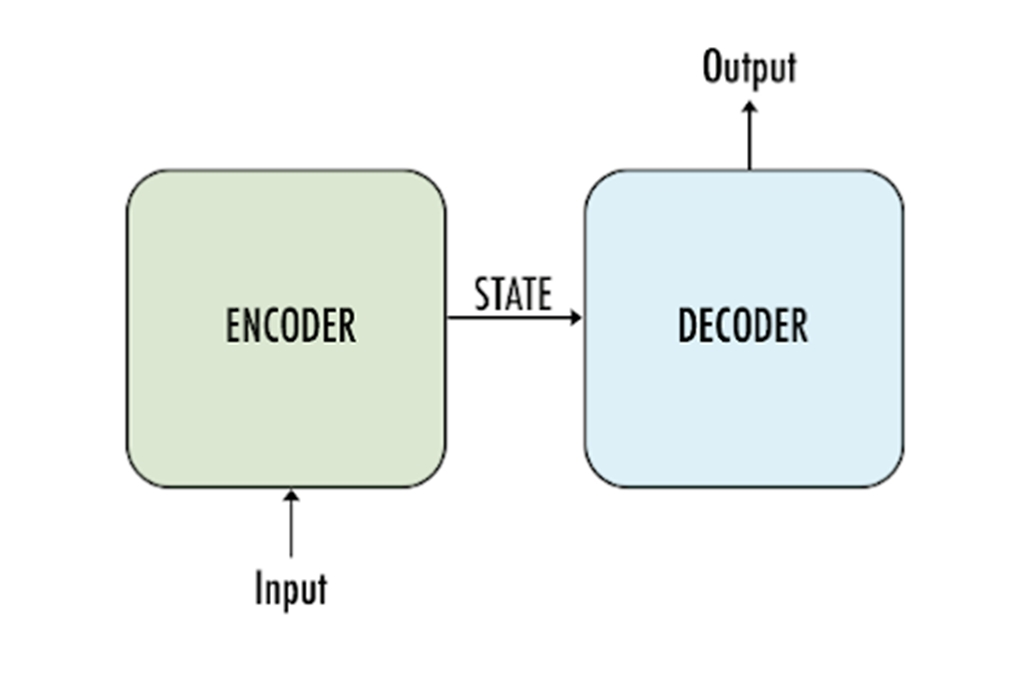

## Обзор тренировочного датасета

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("data/lenta-ru-news.csv", low_memory=False)
data.head(3)

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17


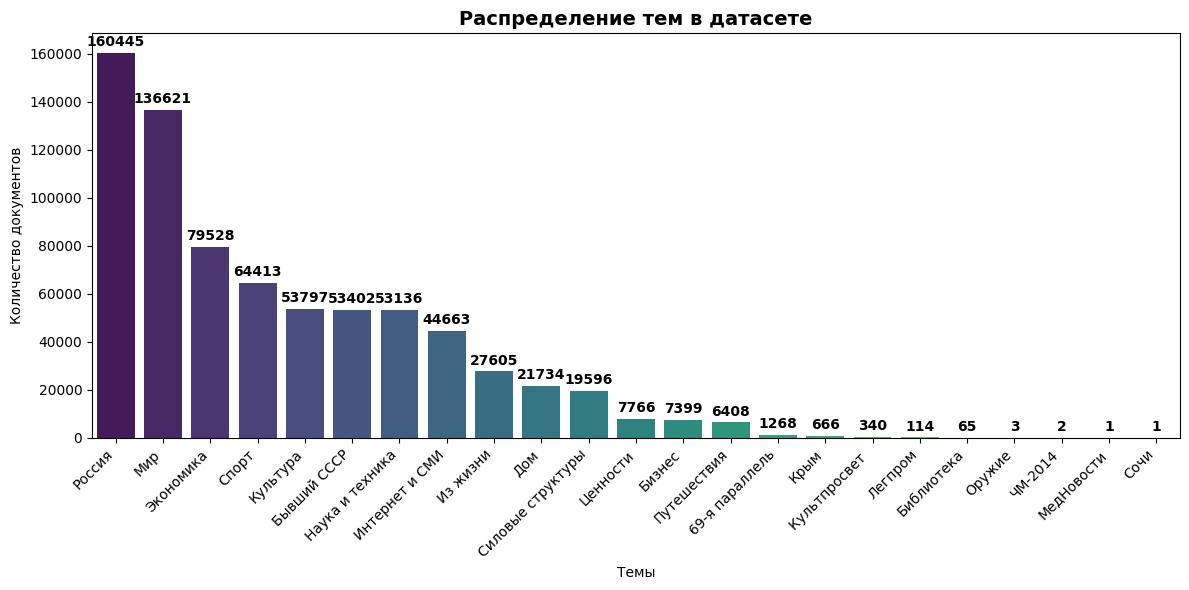

In [3]:
plt.figure(figsize=(12, 6))
topic_counts = data['topic'].value_counts()

ax = sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
plt.title('Распределение тем в датасете', fontsize=14, fontweight='bold')
plt.xlabel('Темы')
plt.ylabel('Количество документов')
plt.xticks(rotation=45, ha='right')

for i, count in enumerate(topic_counts.values):
    ax.text(i, count + max(topic_counts.values)*0.01, str(count), 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [4]:
topics = set(topic_counts[topic_counts > 5000].index)
data = data[data["topic"].apply(lambda x: x in topics)]
data = data[["text", "topic"]].dropna()

train_texts, test_texts, train_labels, test_labels = train_test_split(data["text"], 
                                                                      data["topic"], 
                                                                      random_state=42, 
                                                                      train_size=0.8)
del data

# Bag of words методы в качестве Encoder'a

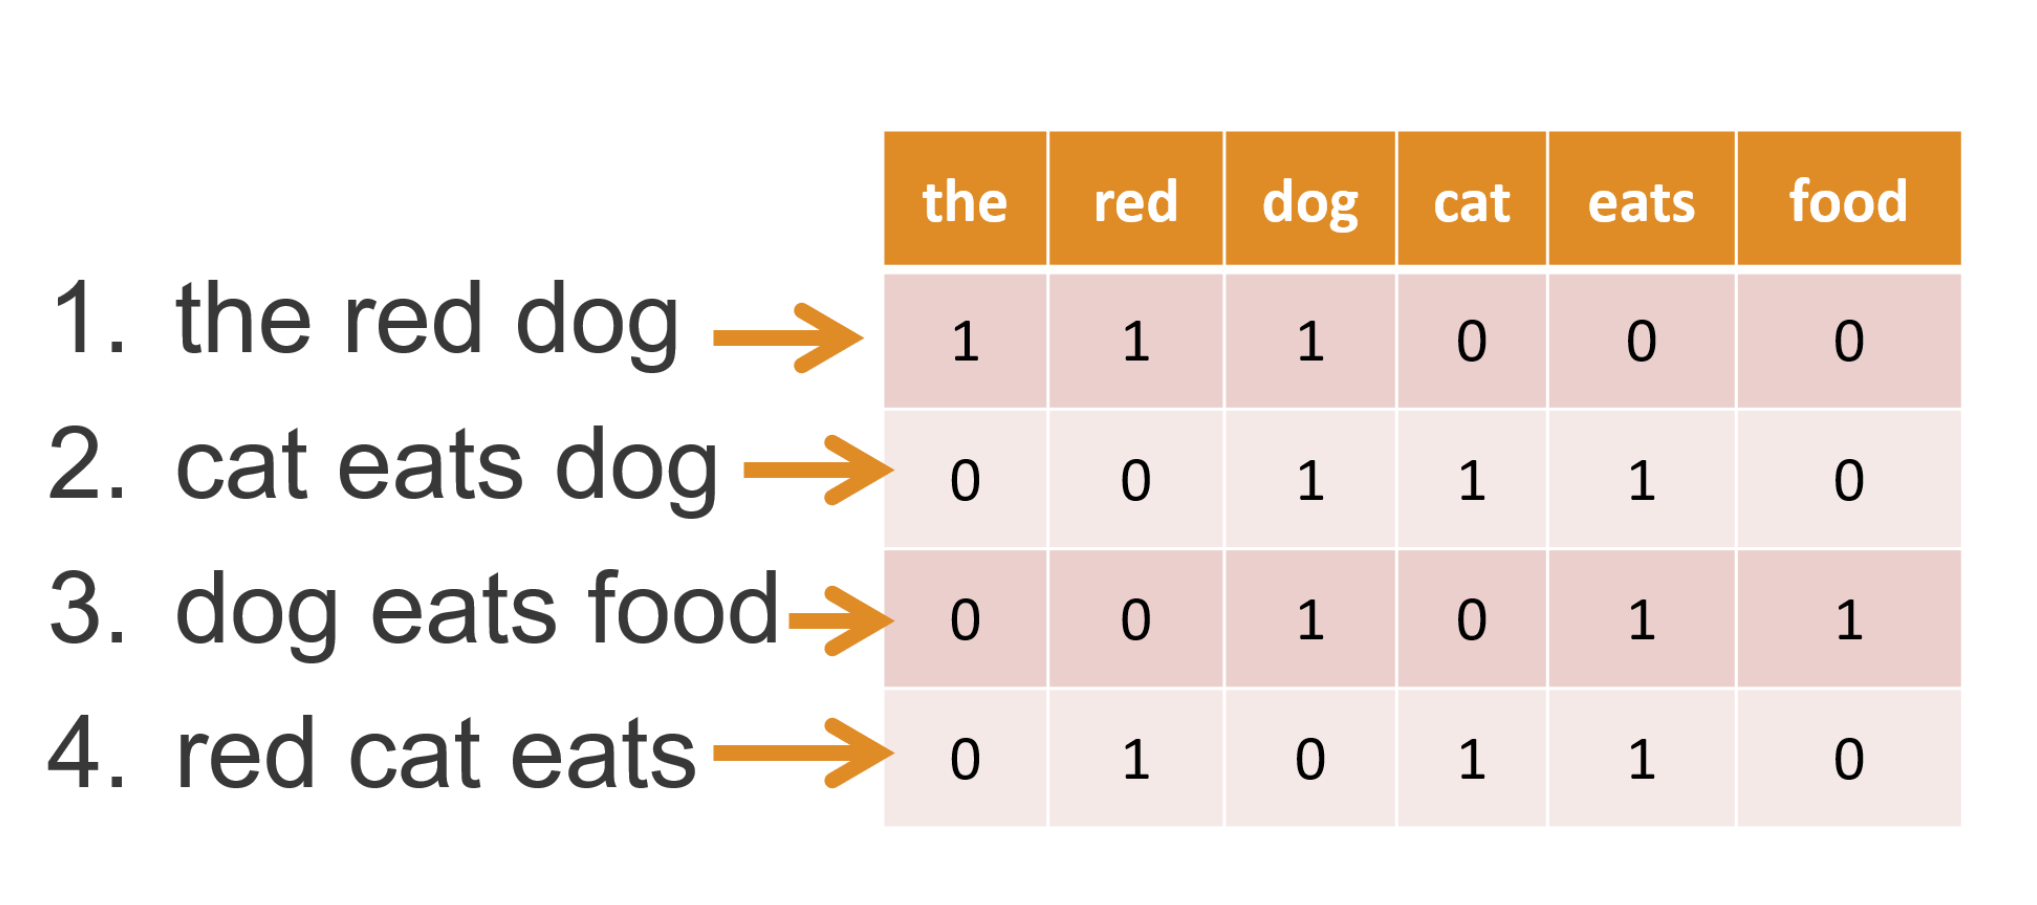

In [ ]:


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

encoder = CountVectorizer()
encoder.fit(train_texts)
train_texts_vectorized = encoder.transform(train_texts)
test_texts_vectorized = encoder.transform(test_texts)

## Очистка текста

100%|███████████████████████████████████████████████████████████████████████| 589206/589206 [00:35<00:00, 16433.86it/s]


2602926


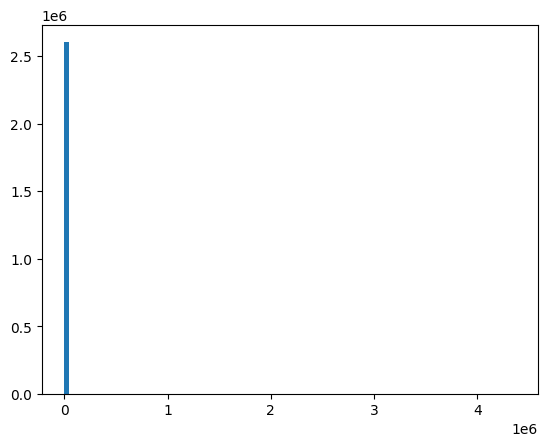

In [5]:
d = dict()
for i in tqdm(train_texts):
    for j in i.split():
        if j in d.keys():
            d[j] += 1
        else:
            d[j] = 1
print(len(d.keys()))
plt.hist(d.values(), bins=100)
plt.show()

In [6]:
def preprocess_text(text: str) -> str:
    # приводим к нижнему регистру
    text = text.lower()
    
    # оставляем только буквы и цифры
    text = "".join([i if (i.isalpha() or i.isdigit()) else " " for i in text])
    
    # удаляем лишние пробелы
    text = " ".join(text.split())
    
    # заменяем цифры на <digit>
    for i in range(10):
        text = text.replace(str(i), " <digit> ")
    
    return text
        
        
train_texts_filtered = [preprocess_text(i) for i in tqdm(train_texts)]

100%|████████████████████████████████████████████████████████████████████████| 589206/589206 [01:16<00:00, 7710.36it/s]


In [7]:
d = dict()
for i in tqdm(train_texts_filtered):
    for j in i.split():
        if j in d.keys():
            d[j] += 1
        else:
            d[j] = 1

100%|███████████████████████████████████████████████████████████████████████| 589206/589206 [00:34<00:00, 17029.26it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:20<00:00,  4.88it/s]


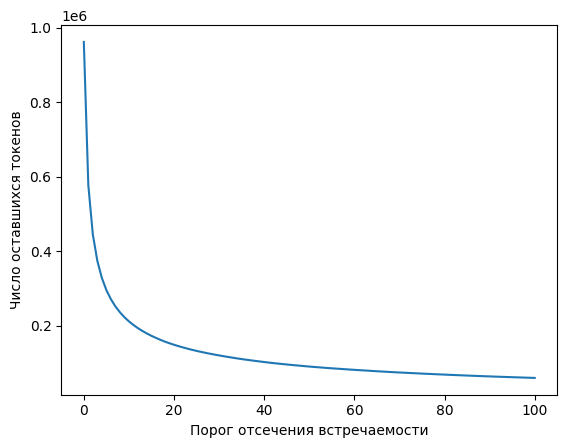

In [8]:
y = []
for i in tqdm(range(101)):
    y.append(len([j for j in d.keys() if d[j] > i]))
plt.plot(range(101), y)
plt.xlabel("Порог отсечения встречаемости")
plt.ylabel("Число оставшихся токенов")
plt.show()

In [9]:
tokens = set([j for j in d.keys() if d[j] > 60])
len(tokens)

81879

In [10]:
train_texts_filtered = [" ".join([j for j in i.split() if j in tokens]) for i in train_texts_filtered]

test_texts_filtered = [preprocess_text(i) for i in tqdm(test_texts)]
test_texts_filtered = [" ".join([j for j in i.split() if j in tokens]) for i in test_texts_filtered]

print(train_texts_filtered[0])

100%|████████████████████████████████████████████████████████████████████████| 147302/147302 [00:18<00:00, 7973.99it/s]


курс единой европейской валюты евро упал ниже уровня в <digit> <digit> <digit> <digit> <digit> доллара за евро впервые за всю историю торгов по этой валюте передает ak m ситуация не изменилась даже после того как центральный банк европы объявил о решении повысить процентные ставки на <digit> <digit> <digit> процента считается что это решение должно укрепить позиции евро однако ожидать скорого повышения курса не стоит отмечают эксперты


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

encoder = CountVectorizer()
encoder.fit(train_texts_filtered)
train_texts_vectorized = encoder.transform(train_texts_filtered)
test_texts_vectorized = encoder.transform(test_texts_filtered)

## Прикрепляем LogisticRegression в качестве Decoder'a

In [12]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_texts_vectorized, train_labels)

y_pred = model.predict(test_texts_vectorized)
print(classification_report(test_labels, y_pred))

                   precision    recall  f1-score   support

           Бизнес       0.61      0.31      0.41      1466
      Бывший СССР       0.83      0.78      0.81     10682
              Дом       0.85      0.78      0.81      4398
         Из жизни       0.64      0.58      0.61      5542
   Интернет и СМИ       0.76      0.69      0.72      8872
         Культура       0.85      0.88      0.87     10620
              Мир       0.79      0.83      0.81     27437
  Наука и техника       0.82      0.83      0.82     10589
      Путешествия       0.82      0.49      0.61      1294
           Россия       0.77      0.83      0.80     32112
Силовые структуры       0.65      0.50      0.57      3966
            Спорт       0.96      0.96      0.96     12946
         Ценности       0.90      0.75      0.82      1558
        Экономика       0.82      0.86      0.84     15820

         accuracy                           0.81    147302
        macro avg       0.79      0.72      0.75    14

## Стемминг и лемматизация

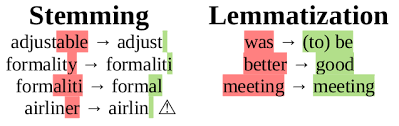

In [ ]:
!python -m spacy download ru_core_news_sm

In [13]:
import spacy

nlp = spacy.load("ru_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

text = "Мама мыла раму, а дети играли в мяч"
lemmatized = lemmatize_text(text)
print(f"Исходный: {text}")
print(f"Лемматизированный: {lemmatized}")

Исходный: Мама мыла раму, а дети играли в мяч
Лемматизированный: мама мыла рама , а ребёнок играть в мяч


In [14]:
train_texts_lemmatized = [lemmatize_text(i) for i in tqdm(train_texts[:50000])]
test_texts_lemmatized = [lemmatize_text(i) for i in tqdm(test_texts[:10000])]

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:35<00:00, 17.38it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:02<00:00, 43.95it/s]


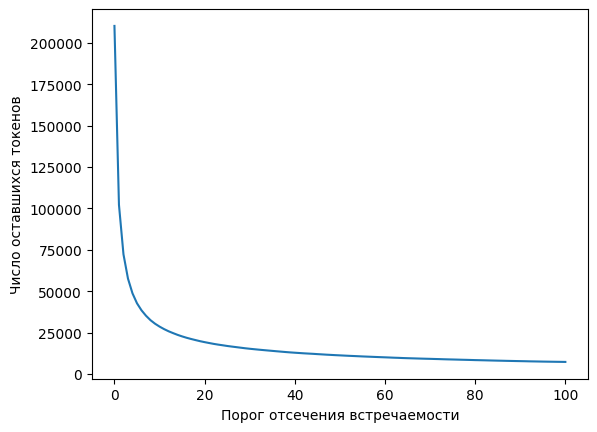

In [15]:
d = dict()
for i in tqdm(train_texts_lemmatized):
    for j in i.split():
        if j in d.keys():
            d[j] += 1
        else:
            d[j] = 1
y = []
for i in tqdm(range(101)):
    y.append(len([j for j in d.keys() if d[j] > i]))
plt.plot(range(101), y)
plt.xlabel("Порог отсечения встречаемости")
plt.ylabel("Число оставшихся токенов")
plt.show()

In [16]:
tokens = set([j for j in d.keys() if d[j] > 30])
train_texts_lemmatized = [" ".join([j for j in i.split() if j in tokens]) for i in train_texts_lemmatized]
test_texts_lemmatized = [" ".join([j for j in i.split() if j in tokens]) for i in test_texts_lemmatized]

print(train_texts_lemmatized[0])

курс единый европейский валюта евро упасть ниже уровень в доллар за евро впервые за весь история торг по этот валюта , передавать ситуация не измениться даже после того , как центральный банк европа объявить о решение повысить процентный ставка на 0,25 процент . считаться , что это решение должный укрепить позиция евро . однако ожидать скорый повышение курс не стоить , отмечать эксперт .


In [17]:
encoder = CountVectorizer()
encoder.fit(train_texts_filtered)
train_texts_vectorized = encoder.transform(train_texts_lemmatized)
test_texts_vectorized = encoder.transform(test_texts_lemmatized)

model = LogisticRegression()
model.fit(train_texts_vectorized, train_labels[:50000])

y_pred = model.predict(test_texts_vectorized)
print(classification_report(test_labels[:10000], y_pred))

                   precision    recall  f1-score   support

           Бизнес       0.51      0.48      0.49       101
      Бывший СССР       0.80      0.77      0.79       720
              Дом       0.78      0.77      0.78       285
         Из жизни       0.60      0.58      0.59       385
   Интернет и СМИ       0.69      0.71      0.70       592
         Культура       0.87      0.85      0.86       754
              Мир       0.76      0.78      0.77      1789
  Наука и техника       0.80      0.76      0.78       723
      Путешествия       0.69      0.62      0.65        99
           Россия       0.75      0.77      0.76      2202
Силовые структуры       0.55      0.53      0.54       272
            Спорт       0.96      0.94      0.95       914
         Ценности       0.90      0.77      0.83       109
        Экономика       0.80      0.83      0.81      1055

         accuracy                           0.78     10000
        macro avg       0.75      0.72      0.74     1

## Tf-Idf encoder

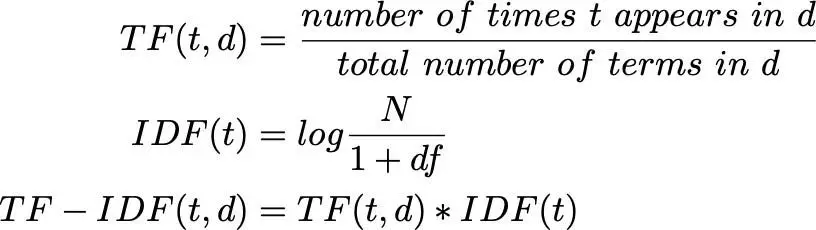

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

encoder = TfidfVectorizer()
encoder.fit(train_texts_filtered)
train_texts_vectorized = encoder.transform(train_texts_lemmatized)
test_texts_vectorized = encoder.transform(test_texts_lemmatized)

model = LogisticRegression()
model.fit(train_texts_vectorized, train_labels[:50000])

y_pred = model.predict(test_texts_vectorized)
print(classification_report(test_labels[:10000], y_pred))

                   precision    recall  f1-score   support

           Бизнес       0.65      0.17      0.27       101
      Бывший СССР       0.83      0.77      0.80       720
              Дом       0.83      0.73      0.77       285
         Из жизни       0.70      0.57      0.63       385
   Интернет и СМИ       0.76      0.68      0.72       592
         Культура       0.88      0.86      0.87       754
              Мир       0.77      0.84      0.81      1789
  Наука и техника       0.80      0.80      0.80       723
      Путешествия       0.71      0.36      0.48        99
           Россия       0.74      0.83      0.78      2202
Силовые структуры       0.66      0.35      0.45       272
            Спорт       0.95      0.95      0.95       914
         Ценности       0.99      0.72      0.83       109
        Экономика       0.80      0.87      0.83      1055

         accuracy                           0.79     10000
        macro avg       0.79      0.68      0.71     1

# Рекурентные нейронные сети в качестве Encoder'a

## Токенизация

Метод **BPE (Byte‑Pair Encoding):**

1. Берут набор символов (включая пробелы и байты).
2. Считают все пары символов/субслов и находят самую частую.
3. Объединяют её в единый токен и добавляют в словарь.
4. Повторяют, пока не достигнут нужного размера словаря.

Пример токенизации:

"Умный человек в очках обои скачать" **=>**

"ум", "ный", " ", "человек", " ", "в", " ", "очк", "ах", " ", "обои", " ", "скач", "ать" **=>**

"\<start\>", "ум", "ный", " ", "человек", " ", "в", " ", "очк", "ах", " ", "обои", " ", "скач", "ать", "\<end\>"**=>**


[2, 34, 76, 1, 678, 1, 33, 1, 435, 58, 1, 33, 1, 17, 92, 3]

## Embedding слой

In [19]:
import torch
from torch import nn

embedding_layer = nn.Embedding(embedding_dim=4, num_embeddings=1000)
tokenized_text = torch.tensor([2, 34, 76, 1, 678, 1, 33, 1, 435, 58, 1, 33, 1, 17, 92, 3])
embeddings = embedding_layer(tokenized_text)
embeddings

tensor([[-2.1785, -1.1661,  0.0866,  0.6692],
        [ 2.4259,  0.7365, -0.2507,  1.3081],
        [-1.3181,  1.2059, -0.1627, -0.1250],
        [-0.5721, -0.9917, -0.1385,  0.3417],
        [-0.2102,  0.7002,  0.2098, -0.7248],
        [-0.5721, -0.9917, -0.1385,  0.3417],
        [-1.9161, -0.3018, -0.1468,  0.3864],
        [-0.5721, -0.9917, -0.1385,  0.3417],
        [ 0.0371, -0.3116,  0.4635,  0.1419],
        [-0.2881,  0.0531, -0.3999, -2.3553],
        [-0.5721, -0.9917, -0.1385,  0.3417],
        [-1.9161, -0.3018, -0.1468,  0.3864],
        [-0.5721, -0.9917, -0.1385,  0.3417],
        [ 1.6342, -0.4923, -0.4687,  1.1219],
        [-0.2723,  1.3803,  0.2843,  1.6494],
        [ 1.4584, -0.6750, -0.6432, -0.2180]], grad_fn=<EmbeddingBackward0>)

Embedding("King") - Embedding("Man") + Embedding("Woman") = Embedding("Queen")

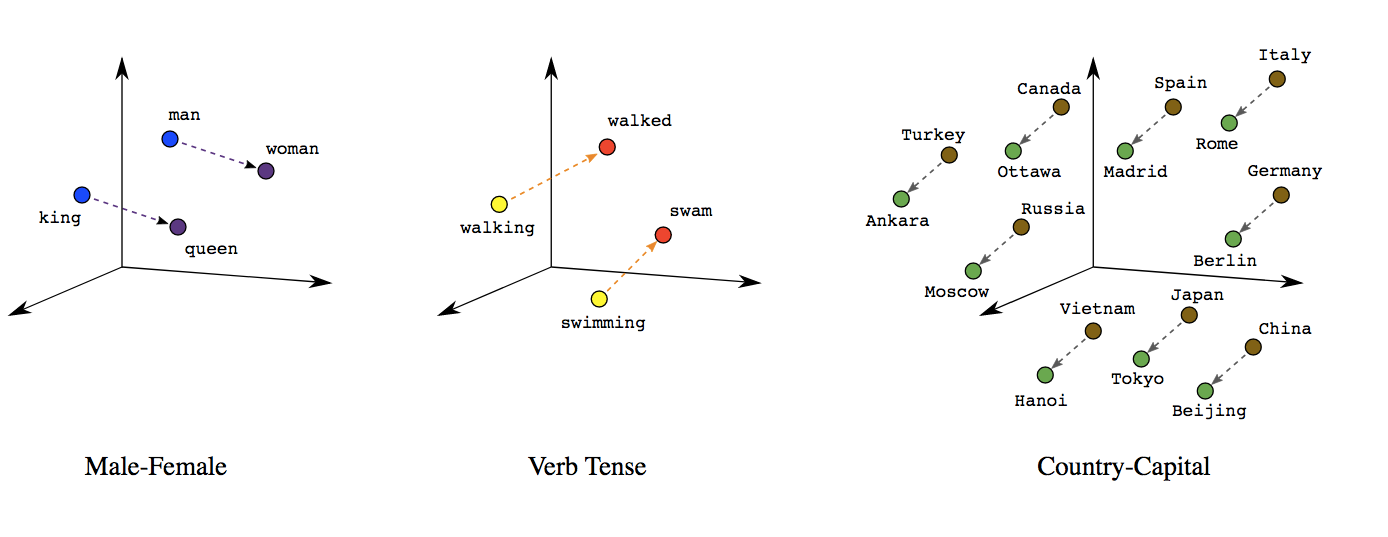

## Рекурентный слой

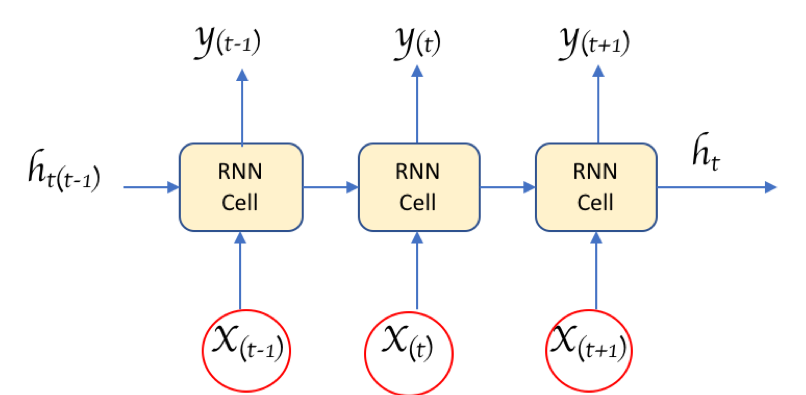

In [21]:
rnn = nn.RNN(input_size=4, 
             hidden_size=8, 
             num_layers=1,
             dropout=0.1,
             bidirectional=False)

print(embeddings.shape)
output, hn = rnn(embeddings)
print(output.shape, hn.shape)

torch.Size([16, 4])
torch.Size([16, 8]) torch.Size([1, 8])


In [22]:
hn

tensor([[ 0.5375, -0.4099, -0.6687, -0.2857, -0.6410, -0.3936, -0.6456,  0.0349]],
       grad_fn=<SqueezeBackward1>)

In [23]:
output

tensor([[-4.3729e-01,  5.0589e-01,  7.5731e-01,  2.7087e-01,  8.2885e-02,
         -5.0986e-01,  8.7140e-01, -3.3559e-01],
        [ 7.5694e-02, -2.4488e-01, -4.1760e-01, -6.4270e-01, -6.1936e-01,
         -8.0190e-01, -6.2339e-01, -4.7485e-01],
        [-6.1288e-01, -2.6356e-02,  7.2104e-01,  8.0936e-01,  4.5062e-01,
         -6.5570e-01,  7.4582e-01, -2.0415e-01],
        [ 1.1500e-01, -1.9211e-01, -2.8381e-01, -2.0483e-02, -4.5535e-01,
         -5.0051e-01,  2.1119e-01, -1.1720e-01],
        [-4.3411e-01, -2.6995e-01,  2.2312e-01,  5.8805e-01,  6.1050e-02,
         -4.3206e-01,  5.4155e-01,  1.8496e-01],
        [-3.7309e-02,  4.4772e-02,  8.3440e-02,  1.0631e-01, -2.4435e-01,
         -3.4426e-01,  4.7595e-01, -1.1280e-01],
        [-4.4418e-01,  2.0677e-01,  5.8405e-01,  5.9843e-01,  3.2134e-02,
         -5.6448e-01,  7.8504e-01, -1.8007e-01],
        [ 1.6539e-01,  2.5628e-02, -9.1736e-02, -2.0540e-02, -4.5527e-01,
         -5.3572e-01,  3.1510e-01, -1.4077e-01],
        [-1.6760

## LSTM слой

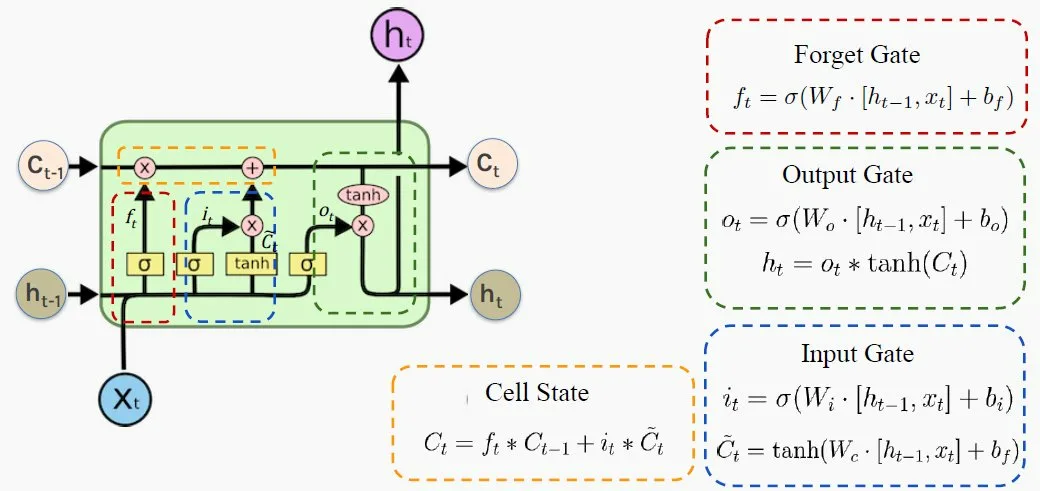

In [24]:
rnn = nn.LSTM(input_size=4, 
              hidden_size=8, 
              num_layers=1,
              dropout=0.1,
              bidirectional=False)

print(embeddings.shape)
output, (hn, cn) = rnn(embeddings)
print(output.shape, hn.shape, cn.shape)

torch.Size([16, 4])
torch.Size([16, 8]) torch.Size([1, 8]) torch.Size([1, 8])


In [25]:
hn

tensor([[-0.2307, -0.2509,  0.0407, -0.0679,  0.1678,  0.0276,  0.1927,  0.0253]],
       grad_fn=<SqueezeBackward1>)

In [26]:
cn

tensor([[-0.4765, -0.6049,  0.0623, -0.1532,  0.5563,  0.0853,  0.6342,  0.0599]],
       grad_fn=<SqueezeBackward1>)

In [27]:
output

tensor([[ 0.0111,  0.0670,  0.1298,  0.1898, -0.1768,  0.1404, -0.0161, -0.0665],
        [-0.3519, -0.2091, -0.0008, -0.0955,  0.0420, -0.0202,  0.2400,  0.1420],
        [-0.1032, -0.2001,  0.1296, -0.0144,  0.0821,  0.0416,  0.2272,  0.0690],
        [-0.0936, -0.0548,  0.1786,  0.0556,  0.0906,  0.0951,  0.1507, -0.0377],
        [-0.0606, -0.1067,  0.2044, -0.0340,  0.1346,  0.0733,  0.2490, -0.0199],
        [-0.0610, -0.0079,  0.2080,  0.0351,  0.1197,  0.1160,  0.1733, -0.0642],
        [-0.0232,  0.0444,  0.1980,  0.1432, -0.0097,  0.1840,  0.1015, -0.1116],
        [-0.0749,  0.0487,  0.2038,  0.1398, -0.0050,  0.1604,  0.0957, -0.1149],
        [-0.0993, -0.0072,  0.1853,  0.0670,  0.0282,  0.1165,  0.2188, -0.0565],
        [-0.0306,  0.0784,  0.2508, -0.0501,  0.1920,  0.0988,  0.0984, -0.1328],
        [-0.0641,  0.0600,  0.2269, -0.0021,  0.1435,  0.1490,  0.1327, -0.0962],
        [-0.0234,  0.0905,  0.2061,  0.1166, -0.0010,  0.2013,  0.0640, -0.1281],
        [-0.0761

## Собираем полноценную сетку для классификации

In [28]:
class RnnClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                           batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Encoder block
        x = self.embedding(x)
        x = self.dropout(x)
        lstm_out, (hidden, cell) = self.lstm(x)
        x = lstm_out[:, -1, :]
        
        # Decoder block
        x = self.linear(x)
        return x

In [30]:
model = RnnClassifier(100, 64, 128, 7, 2, 0.1)
model(torch.tensor([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]))

tensor([[ 0.0311,  0.0122,  0.0161,  0.0771, -0.0844, -0.0565,  0.0611],
        [ 0.0202,  0.0050,  0.0424,  0.0927, -0.0740, -0.0369,  0.0718]],
       grad_fn=<AddmmBackward0>)

In [31]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        sequence = self.tokenizer.texts_to_sequences([text])[0]        
        if len(sequence) < self.max_len:
            sequence = sequence + [0] * (self.max_len - len(sequence))
        else:
            sequence = sequence[:self.max_len]
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(label, dtype=torch.long)

class Tokenizer:
    def __init__(self, num_words=10000):
        self.num_words = num_words
        self.word_index = {}
        self.index_word = {}
        
    def fit_on_texts(self, texts):
        d = dict()
        for text in texts:
            for word in text.split():
                if word in d.keys():
                    d[word] += 1
                else:
                    d[word] = 1                
        d = sorted(d.items(), key=lambda x: x[1], reverse=True)

        self.word_index = {'<PAD>': 0, '<UNK>': 1}
        self.index_word = {0: '<PAD>', 1: '<UNK>'}
        
        for idx, (word, count) in enumerate(d[:self.num_words-2]):
            self.word_index[word] = idx + 2
            self.index_word[idx + 2] = word
            
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = []
            for word in text.split():
                sequence.append(self.word_index.get(word, 1))
            sequences.append(sequence)
        return sequences

In [32]:
train_x = [preprocess_text(i) for i in tqdm(train_texts)]
test_x = [preprocess_text(i) for i in tqdm(test_texts)]

100%|████████████████████████████████████████████████████████████████████████| 147302/147302 [00:18<00:00, 7772.24it/s]


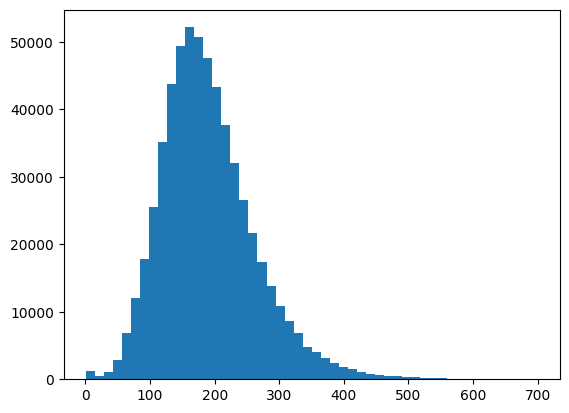

In [40]:
lengths = [len(i.split()) for i in train_x if len(i.split()) < 700]
plt.hist(lengths, bins=50)
plt.show()

In [66]:
from sklearn.preprocessing import LabelEncoder


VOCAB_SIZE = 20000
NUM_EPOCHES = 20
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = len(set(train_labels))
N_LAYERS = 3
LR = 0.001
DROPOUT = 0.2
MAX_LEN = 300
BATCH_SIZE = 1024
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

tokenizer = Tokenizer(num_words=VOCAB_SIZE-1)
tokenizer.fit_on_texts(train_x)

label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_labels)
test_y = label_encoder.transform(test_labels)


train_dataset = TextDataset(train_x, train_y, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TextDataset(test_x, test_y, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = RnnClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

cuda


Для максимального ускорения подбираем максиамльный BATCH_SIZE, пока не упремся в gpu память
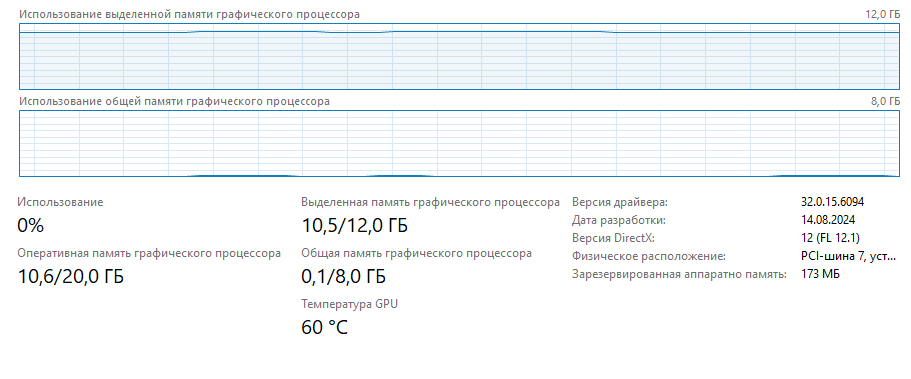

In [67]:
train_losses = []
train_acc = []
test_losses = []
test_acc = []
log_period = 50

if torch.cuda.is_available():
    torch.cuda.empty_cache()
for epoch in range(NUM_EPOCHES):
    print("===== TRAINING =====")
    model.train()
    total_loss = 0
    correct = 0
    total = 0
        
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
            
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
        
        if batch_idx % log_period == (log_period - 1):
            train_losses.append(total_loss / log_period)
            train_acc.append(100 * correct / total)
            print(f"Epoch {epoch + 1}/{NUM_EPOCHES}, Batch {batch_idx + 1}/{len(train_loader)}: Loss = {train_losses[-1]}, Acc = {train_acc[-1]}")
            total_loss = 0
            correct = 0
            total = 0
    print()
    print("===== VALIDATION =====")
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
        
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target).item()
            total_loss += loss
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    test_losses.append(total_loss / len(test_loader))
    test_acc.append(100 * correct / total)
        
    print(f"Epoch {epoch + 1}/{NUM_EPOCHES}: Test Loss = {test_losses[-1]}, Test Accuracy = {test_acc[-1]}")
    print()
    

===== TRAINING =====
Epoch 1/20, Batch 50/576: Loss = 2.343756327629089, Acc = 20.134765625
Epoch 1/20, Batch 100/576: Loss = 2.2988497591018677, Acc = 21.947265625
Epoch 1/20, Batch 150/576: Loss = 2.2950293159484865, Acc = 21.4140625
Epoch 1/20, Batch 200/576: Loss = 2.2247895288467405, Acc = 22.076171875
Epoch 1/20, Batch 250/576: Loss = 2.0720818567276003, Acc = 28.98046875
Epoch 1/20, Batch 300/576: Loss = 1.9531089210510253, Acc = 34.193359375
Epoch 1/20, Batch 350/576: Loss = 1.8760583972930909, Acc = 36.869140625
Epoch 1/20, Batch 400/576: Loss = 1.8582155203819275, Acc = 38.091796875
Epoch 1/20, Batch 450/576: Loss = 1.7934251022338867, Acc = 39.87109375
Epoch 1/20, Batch 500/576: Loss = 1.7578599262237549, Acc = 41.55859375
Epoch 1/20, Batch 550/576: Loss = 1.695358235836029, Acc = 43.353515625

===== VALIDATION =====
Epoch 1/20: Test Loss = 1.6828747929798231, Test Accuracy = 42.662014093494996

===== TRAINING =====
Epoch 2/20, Batch 50/576: Loss = 1.8360264277458191, Acc = 

Epoch 10/20, Batch 50/576: Loss = 0.5053793233633042, Acc = 82.80859375
Epoch 10/20, Batch 100/576: Loss = 0.5086527454853058, Acc = 82.6640625
Epoch 10/20, Batch 150/576: Loss = 0.5077777051925659, Acc = 82.759765625
Epoch 10/20, Batch 200/576: Loss = 0.5110923945903778, Acc = 82.609375
Epoch 10/20, Batch 250/576: Loss = 0.5084513038396835, Acc = 82.7265625
Epoch 10/20, Batch 300/576: Loss = 0.5042146790027618, Acc = 82.609375
Epoch 10/20, Batch 350/576: Loss = 0.5032488071918487, Acc = 82.869140625
Epoch 10/20, Batch 400/576: Loss = 0.4982665503025055, Acc = 82.943359375
Epoch 10/20, Batch 450/576: Loss = 0.5001828145980834, Acc = 82.935546875
Epoch 10/20, Batch 500/576: Loss = 0.5057678663730621, Acc = 82.9453125
Epoch 10/20, Batch 550/576: Loss = 0.509853429198265, Acc = 82.44140625

===== VALIDATION =====
Epoch 10/20: Test Loss = 0.5017060480184026, Test Accuracy = 82.76941249949084

===== TRAINING =====
Epoch 11/20, Batch 50/576: Loss = 0.49655378103256226, Acc = 83.072265625
Epo


===== VALIDATION =====
Epoch 18/20: Test Loss = 0.4453995801094506, Test Accuracy = 84.48425683290111

===== TRAINING =====
Epoch 19/20, Batch 50/576: Loss = 0.37530883073806764, Acc = 86.630859375
Epoch 19/20, Batch 100/576: Loss = 0.3771545904874802, Acc = 86.54296875
Epoch 19/20, Batch 150/576: Loss = 0.38247708320617674, Acc = 86.28515625
Epoch 19/20, Batch 200/576: Loss = 0.3842008060216904, Acc = 86.3046875
Epoch 19/20, Batch 250/576: Loss = 0.37948002099990846, Acc = 86.31640625
Epoch 19/20, Batch 300/576: Loss = 0.37836085677146913, Acc = 86.31640625
Epoch 19/20, Batch 350/576: Loss = 0.38400701224803924, Acc = 86.318359375
Epoch 19/20, Batch 400/576: Loss = 0.3870935148000717, Acc = 86.126953125
Epoch 19/20, Batch 450/576: Loss = 0.3812979257106781, Acc = 86.2265625
Epoch 19/20, Batch 500/576: Loss = 0.37715168356895445, Acc = 86.50390625
Epoch 19/20, Batch 550/576: Loss = 0.38580346286296846, Acc = 86.19921875

===== VALIDATION =====
Epoch 19/20: Test Loss = 0.43529602471325

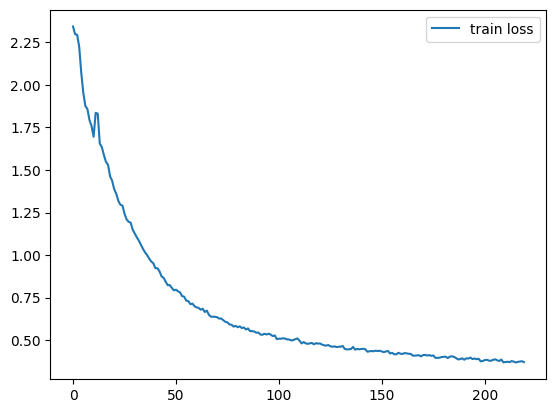

In [68]:
plt.plot(train_losses, label="train loss")
plt.legend()
plt.show()

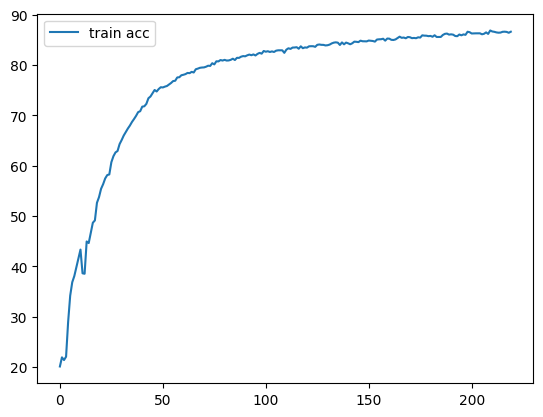

In [69]:
plt.plot(train_acc, label="train acc")
plt.legend()
plt.show()

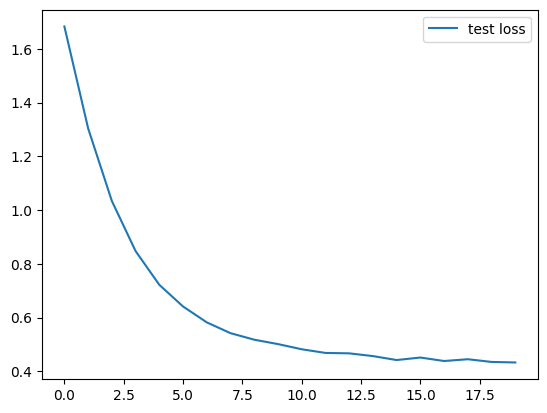

In [70]:
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

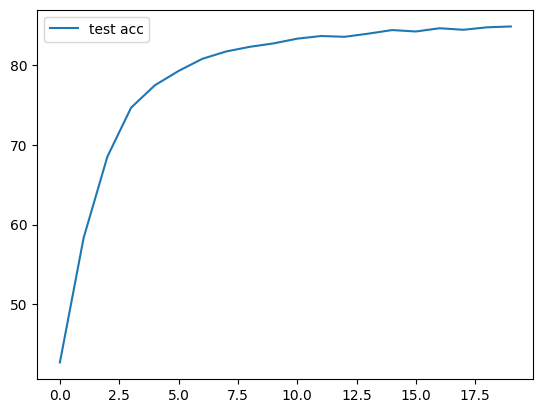

In [71]:
plt.plot(test_acc, label="test acc")
plt.legend()
plt.show()

In [72]:
def predict(text: str) -> str:
    sequence = tokenizer.texts_to_sequences([text])[0]        
    if len(sequence) < MAX_LEN:
        sequence = sequence + [0] * (MAX_LEN - len(sequence))
    else:
        sequence = sequence[:MAX_LEN]
    text = torch.tensor([sequence], dtype=torch.long).to(device)
    y_pred = model(text).argmax(dim=1)
    return label_encoder.classes_[y_pred[0]]
    
    
print(predict("Криштиану Роналду вчера забил гол и стал лучшим бомбардиром Португалии."))
print(predict("Руководство британской Би-Би-Си ушло в отставку после подделки видео выступления Трампа, — Sky News"))
print(predict("Легендарных игрушек Funko Pop больше не будет. Чистый убыток компании Funko достиг $1 млн, прибыль упала на 14%, а продажи — на 20%."))

Спорт
Культура
Экономика


# Attention-based модели

Q = nn.Linear1(embeddings)

K = nn.Linear2(embeddings)

V = nn.Linear3(embeddings)

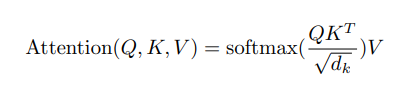

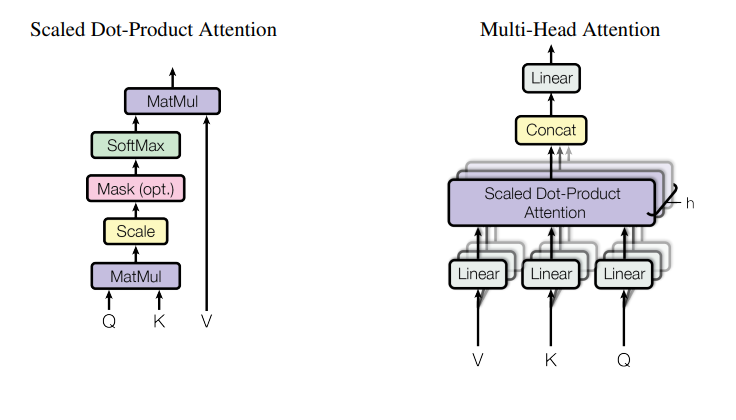

**Трансформер** - архитектура, в которой в качестве единственного слоя обмена информацией между токенами используется attention

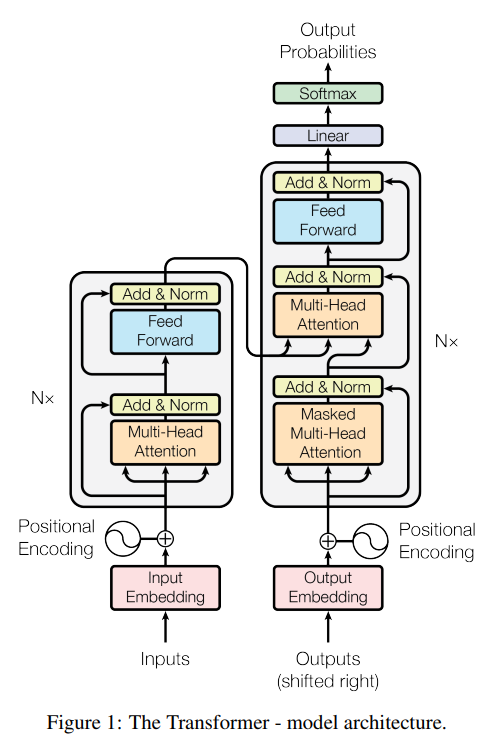

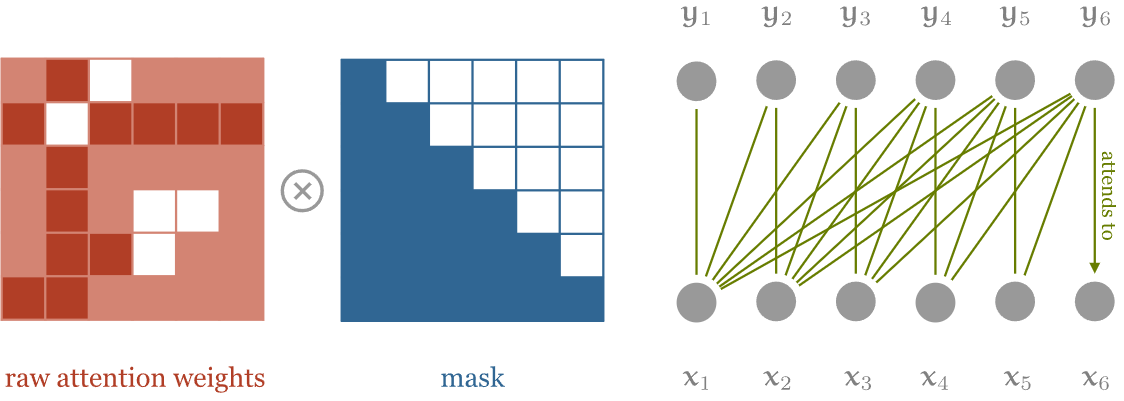

In [74]:
encoder_layer = nn.TransformerEncoderLayer(
            d_model=64,
            nhead=8,
            dim_feedforward=64,
            dropout=0.2,
            activation='relu',
            batch_first=True
        )
encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)

x = torch.rand(1, 300, 64)
encoder(x).shape

torch.Size([1, 300, 64])

In [78]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, hidden_dim, num_classes, num_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.transformer_encoder(x)
        x = x.transpose(1, 2)
        x = self.pool(x).squeeze(2)
        output = self.classifier(x)
        return output

In [79]:
model = TransformerClassifier(100, 64, 8, 64, 7, 2, 0.1)
model(torch.tensor([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]))

tensor([[-0.4119,  0.1068, -0.6671,  0.1660, -0.0748, -0.3352, -0.1679],
        [-0.0206,  0.1505,  0.3156,  0.3626, -0.3536,  0.0347,  0.4360]],
       grad_fn=<AddmmBackward0>)

In [89]:
VOCAB_SIZE = 20000
NUM_EPOCHES = 20
EMBEDDING_DIM = 64
HIDDEN_DIM = 64
NUM_HEADS = 8
OUTPUT_DIM = len(set(train_labels))
N_LAYERS = 4
LR = 0.001
DROPOUT = 0.2
MAX_LEN = 256
BATCH_SIZE = 2048
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

tokenizer = Tokenizer(num_words=VOCAB_SIZE-1)
tokenizer.fit_on_texts(train_x)

label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_labels)
test_y = label_encoder.transform(test_labels)


train_dataset = TextDataset(train_x, train_y, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TextDataset(test_x, test_y, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = TransformerClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    hidden_dim=HIDDEN_DIM,
    num_classes=OUTPUT_DIM,
    num_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

cuda


In [90]:
train_losses = []
train_acc = []
test_losses = []
test_acc = []
log_period = 25

if torch.cuda.is_available():
    torch.cuda.empty_cache()
for epoch in range(NUM_EPOCHES):
    print("===== TRAINING =====")
    model.train()
    total_loss = 0
    correct = 0
    total = 0
        
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
            
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
        
        if batch_idx % log_period == (log_period - 1):
            train_losses.append(total_loss / log_period)
            train_acc.append(100 * correct / total)
            print(f"Epoch {epoch + 1}/{NUM_EPOCHES}, Batch {batch_idx + 1}/{len(train_loader)}: Loss = {train_losses[-1]}, Acc = {train_acc[-1]}")
            total_loss = 0
            correct = 0
            total = 0
    print()
    print("===== VALIDATION =====")
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
        
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target).item()
            total_loss += loss
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    test_losses.append(total_loss / len(test_loader))
    test_acc.append(100 * correct / total)
        
    print(f"Epoch {epoch + 1}/{NUM_EPOCHES}: Test Loss = {test_losses[-1]}, Test Accuracy = {test_acc[-1]}")
    print()
    

===== TRAINING =====
Epoch 1/20, Batch 25/288: Loss = 2.279574909210205, Acc = 22.654296875
Epoch 1/20, Batch 50/288: Loss = 2.026696300506592, Acc = 30.568359375
Epoch 1/20, Batch 75/288: Loss = 1.8406715297698975, Acc = 37.7421875
Epoch 1/20, Batch 100/288: Loss = 1.6263223266601563, Acc = 46.70703125
Epoch 1/20, Batch 125/288: Loss = 1.4513014364242554, Acc = 53.216796875
Epoch 1/20, Batch 150/288: Loss = 1.3217989921569824, Acc = 57.84375
Epoch 1/20, Batch 175/288: Loss = 1.2113349008560181, Acc = 61.662109375
Epoch 1/20, Batch 200/288: Loss = 1.1403674745559693, Acc = 64.10546875
Epoch 1/20, Batch 225/288: Loss = 1.077554430961609, Acc = 66.220703125
Epoch 1/20, Batch 250/288: Loss = 1.0196559643745422, Acc = 68.1484375
Epoch 1/20, Batch 275/288: Loss = 0.9682076597213745, Acc = 69.59375

===== VALIDATION =====
Epoch 1/20: Test Loss = 0.8975419311059846, Test Accuracy = 71.96983068797437

===== TRAINING =====
Epoch 2/20, Batch 25/288: Loss = 0.9108117175102234, Acc = 71.36328125
E

Epoch 10/20, Batch 25/288: Loss = 0.47736516237258914, Acc = 83.455078125
Epoch 10/20, Batch 50/288: Loss = 0.47550514578819275, Acc = 83.51171875
Epoch 10/20, Batch 75/288: Loss = 0.47357781410217287, Acc = 83.5625
Epoch 10/20, Batch 100/288: Loss = 0.4680116879940033, Acc = 83.72265625
Epoch 10/20, Batch 125/288: Loss = 0.47342512011528015, Acc = 83.484375
Epoch 10/20, Batch 150/288: Loss = 0.4769906568527222, Acc = 83.2734375
Epoch 10/20, Batch 175/288: Loss = 0.4845783197879791, Acc = 83.16796875
Epoch 10/20, Batch 200/288: Loss = 0.4753932619094849, Acc = 83.46484375
Epoch 10/20, Batch 225/288: Loss = 0.48241586327552793, Acc = 83.033203125
Epoch 10/20, Batch 250/288: Loss = 0.47925694346427916, Acc = 83.197265625
Epoch 10/20, Batch 275/288: Loss = 0.48105080604553224, Acc = 83.2109375

===== VALIDATION =====
Epoch 10/20: Test Loss = 0.49561162996623254, Test Accuracy = 82.82575932438121

===== TRAINING =====
Epoch 11/20, Batch 25/288: Loss = 0.46149994850158693, Acc = 83.95117187


===== VALIDATION =====
Epoch 18/20: Test Loss = 0.4678867753181193, Test Accuracy = 83.69132801998614

===== TRAINING =====
Epoch 19/20, Batch 25/288: Loss = 0.40041906118392945, Acc = 85.541015625
Epoch 19/20, Batch 50/288: Loss = 0.4073704183101654, Acc = 85.361328125
Epoch 19/20, Batch 75/288: Loss = 0.40808221220970153, Acc = 85.375
Epoch 19/20, Batch 100/288: Loss = 0.4022941553592682, Acc = 85.6640625
Epoch 19/20, Batch 125/288: Loss = 0.4089709782600403, Acc = 85.279296875
Epoch 19/20, Batch 150/288: Loss = 0.4069842410087585, Acc = 85.49609375
Epoch 19/20, Batch 175/288: Loss = 0.41604581356048587, Acc = 85.138671875
Epoch 19/20, Batch 200/288: Loss = 0.40738322615623473, Acc = 85.5234375
Epoch 19/20, Batch 225/288: Loss = 0.40310148119926453, Acc = 85.484375
Epoch 19/20, Batch 250/288: Loss = 0.4118122923374176, Acc = 85.21875
Epoch 19/20, Batch 275/288: Loss = 0.41187472343444825, Acc = 85.26953125

===== VALIDATION =====
Epoch 19/20: Test Loss = 0.46653686505224967, Test Ac

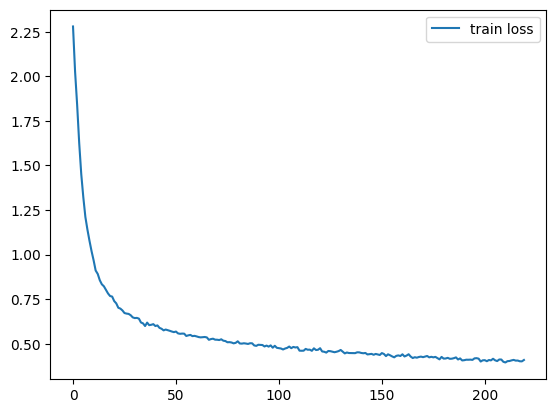

In [91]:
plt.plot(train_losses, label="train loss")
plt.legend()
plt.show()

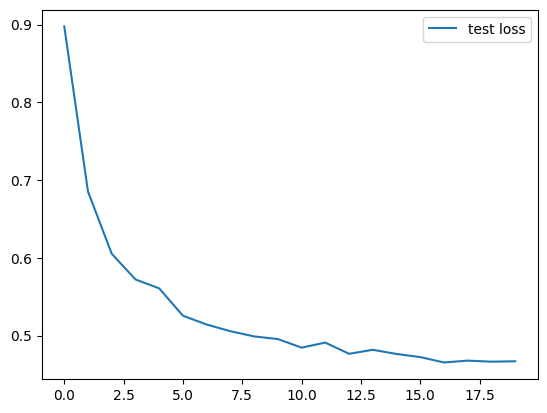

In [92]:
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

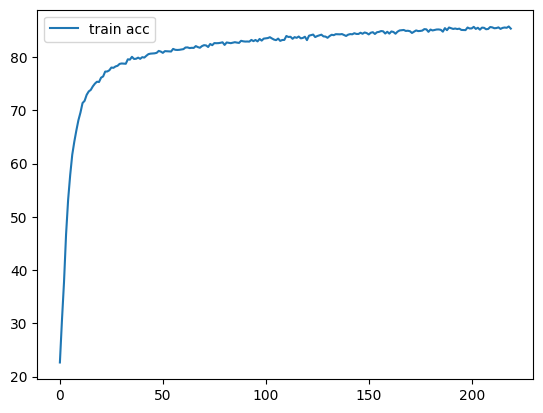

In [93]:
plt.plot(train_acc, label="train acc")
plt.legend()
plt.show()

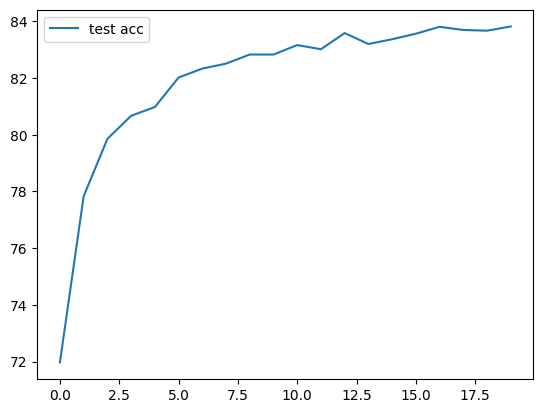

In [94]:
plt.plot(test_acc, label="test acc")
plt.legend()
plt.show()

In [95]:
def predict(text: str) -> str:
    sequence = tokenizer.texts_to_sequences([text])[0]        
    if len(sequence) < MAX_LEN:
        sequence = sequence + [0] * (MAX_LEN - len(sequence))
    else:
        sequence = sequence[:MAX_LEN]
    text = torch.tensor([sequence], dtype=torch.long).to(device)
    y_pred = model(text).argmax(dim=1)
    return label_encoder.classes_[y_pred[0]]
    
    
print(predict("Криштиану Роналду вчера забил гол и стал лучшим бомбардиром Португалии."))
print(predict("Руководство британской Би-Би-Си ушло в отставку после подделки видео выступления Трампа, — Sky News"))
print(predict("Легендарных игрушек Funko Pop больше не будет. Чистый убыток компании Funko достиг $1 млн, прибыль упала на 14%, а продажи — на 20%."))

Спорт
Путешествия
Экономика


## Transfer-learning

In [124]:
class TextDatasetTL(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = [i for i in texts]
        self.labels = [i for i in labels]
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [132]:
from transformers import AutoModel, AutoTokenizer


class CustomBERT(nn.Module):
    def __init__(self, model_name, num_classes, dropout):
        super().__init__()
        
        self.encoder = AutoModel.from_pretrained(model_name)
        bert_hidden_size = self.encoder.config.hidden_size
        
        self.decoder = nn.Linear(bert_hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, attention_mask=None):
        x = self.encoder(
                input_ids=x,
                attention_mask=attention_mask,
                return_dict=True
        )
        
        x = x.last_hidden_state[:, 0, :] 
        x = self.dropout(x)
        logits = self.decoder(x)
        return logits


In [133]:
VOCAB_SIZE = 20000
NUM_EPOCHES = 10
OUTPUT_DIM = len(set(train_labels))
LR = 0.001
DROPOUT = 0.2
MAX_LEN = 256
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_name='cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(model_name)    
model = CustomBERT(
            model_name, 
            num_classes=OUTPUT_DIM,
            dropout=0.2
        ).to(device)

label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_labels)
test_y = label_encoder.transform(test_labels)


train_dataset = TextDatasetTL(train_texts, train_y, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TextDatasetTL(test_texts, test_y, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

cuda


In [134]:
train_losses = []
train_acc = []
test_losses = []
test_acc = []
log_period = 100

if torch.cuda.is_available():
    torch.cuda.empty_cache()
for epoch in range(NUM_EPOCHES):
    print("===== TRAINING =====")
    model.train()
    total_loss = 0
    correct = 0
    total = 0
        
    for batch_idx, dataset_str in enumerate(train_loader):
        data, target, attention_mask = dataset_str["input_ids"], dataset_str["labels"], dataset_str["attention_mask"]
        data, target, attention_mask = data.to(device), target.to(device), attention_mask.to(device)
            
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
        
        if batch_idx % log_period == (log_period - 1):
            train_losses.append(total_loss / log_period)
            train_acc.append(100 * correct / total)
            print(f"Epoch {epoch + 1}/{NUM_EPOCHES}, Batch {batch_idx + 1}/{len(train_loader)}: Loss = {train_losses[-1]}, Acc = {train_acc[-1]}")
            total_loss = 0
            correct = 0
            total = 0
    print()
    print("===== VALIDATION =====")
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
        
    with torch.no_grad():
        for batch_idx, dataset_str in enumerate(test_loader):
            data, target, attention_mask = dataset_str["input_ids"], dataset_str["labels"], dataset_str["attention_mask"]
            data, target, attention_mask = data.to(device), target.to(device), attention_mask.to(device)
            output = model(data)
            loss = criterion(output, target).item()
            total_loss += loss
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    test_losses.append(total_loss / len(test_loader))
    test_acc.append(100 * correct / total)
        
    print(f"Epoch {epoch + 1}/{NUM_EPOCHES}: Test Loss = {test_losses[-1]}, Test Accuracy = {test_acc[-1]}")
    print()
    

===== TRAINING =====
Epoch 1/10, Batch 100/4604: Loss = 0.9935104936361313, Acc = 69.15625
Epoch 1/10, Batch 200/4604: Loss = 0.6810991063714027, Acc = 77.765625
Epoch 1/10, Batch 300/4604: Loss = 0.6486118170619011, Acc = 78.53125
Epoch 1/10, Batch 400/4604: Loss = 0.6186607363820076, Acc = 79.546875
Epoch 1/10, Batch 500/4604: Loss = 0.574550393819809, Acc = 80.8984375
Epoch 1/10, Batch 600/4604: Loss = 0.584544997215271, Acc = 80.5234375
Epoch 1/10, Batch 700/4604: Loss = 0.5898136794567108, Acc = 79.84375
Epoch 1/10, Batch 800/4604: Loss = 0.5719302499294281, Acc = 80.8671875
Epoch 1/10, Batch 900/4604: Loss = 0.5604177755117417, Acc = 81.4765625
Epoch 1/10, Batch 1000/4604: Loss = 0.5420958384871483, Acc = 81.6015625
Epoch 1/10, Batch 1100/4604: Loss = 0.5243799412250518, Acc = 82.3203125
Epoch 1/10, Batch 1200/4604: Loss = 0.5400278061628342, Acc = 81.6953125
Epoch 1/10, Batch 1300/4604: Loss = 0.5545921295881271, Acc = 81.265625
Epoch 1/10, Batch 1400/4604: Loss = 0.527303586900

Epoch 3/10, Batch 1900/4604: Loss = 0.35543842151761057, Acc = 87.6015625
Epoch 3/10, Batch 2000/4604: Loss = 0.3852382878959179, Acc = 86.40625
Epoch 3/10, Batch 2100/4604: Loss = 0.3759173576533794, Acc = 86.5625
Epoch 3/10, Batch 2200/4604: Loss = 0.3743128174543381, Acc = 86.8828125
Epoch 3/10, Batch 2300/4604: Loss = 0.3903346510231495, Acc = 86.6640625
Epoch 3/10, Batch 2400/4604: Loss = 0.3755758288502693, Acc = 87.1015625
Epoch 3/10, Batch 2500/4604: Loss = 0.3838194803893566, Acc = 86.7265625
Epoch 3/10, Batch 2600/4604: Loss = 0.3851091504096985, Acc = 86.4296875
Epoch 3/10, Batch 2700/4604: Loss = 0.3863835436105728, Acc = 86.3828125
Epoch 3/10, Batch 2800/4604: Loss = 0.3654571974277496, Acc = 87.2421875
Epoch 3/10, Batch 2900/4604: Loss = 0.37879798576235774, Acc = 86.796875
Epoch 3/10, Batch 3000/4604: Loss = 0.39433387443423273, Acc = 86.171875
Epoch 3/10, Batch 3100/4604: Loss = 0.38804022818803785, Acc = 86.2109375
Epoch 3/10, Batch 3200/4604: Loss = 0.3813380225002765

Epoch 5/10, Batch 3700/4604: Loss = 0.3362633861601353, Acc = 88.328125
Epoch 5/10, Batch 3800/4604: Loss = 0.34068182289600374, Acc = 88.03125
Epoch 5/10, Batch 3900/4604: Loss = 0.3500807748734951, Acc = 87.4921875
Epoch 5/10, Batch 4000/4604: Loss = 0.3414987698197365, Acc = 88.2265625
Epoch 5/10, Batch 4100/4604: Loss = 0.32477189615368846, Acc = 88.765625
Epoch 5/10, Batch 4200/4604: Loss = 0.3325795511901379, Acc = 88.1484375
Epoch 5/10, Batch 4300/4604: Loss = 0.332482597976923, Acc = 88.21875
Epoch 5/10, Batch 4400/4604: Loss = 0.34134149953722953, Acc = 87.9296875
Epoch 5/10, Batch 4500/4604: Loss = 0.33280183643102645, Acc = 88.375
Epoch 5/10, Batch 4600/4604: Loss = 0.3247345270216465, Acc = 88.65625

===== VALIDATION =====
Epoch 5/10: Test Loss = 0.5020872465586476, Test Accuracy = 83.69472240702774

===== TRAINING =====
Epoch 6/10, Batch 100/4604: Loss = 0.27095108449459077, Acc = 90.4375
Epoch 6/10, Batch 200/4604: Loss = 0.2693253034353256, Acc = 90.09375
Epoch 6/10, Bat

Epoch 8/10, Batch 800/4604: Loss = 0.24853884294629097, Acc = 91.34375
Epoch 8/10, Batch 900/4604: Loss = 0.24869658380746842, Acc = 91.0859375
Epoch 8/10, Batch 1000/4604: Loss = 0.23253370746970176, Acc = 91.453125
Epoch 8/10, Batch 1100/4604: Loss = 0.2511892065405846, Acc = 91.0078125
Epoch 8/10, Batch 1200/4604: Loss = 0.2520032413303852, Acc = 91.0078125
Epoch 8/10, Batch 1300/4604: Loss = 0.2356800189614296, Acc = 91.34375
Epoch 8/10, Batch 1400/4604: Loss = 0.24346505492925644, Acc = 91.2265625
Epoch 8/10, Batch 1500/4604: Loss = 0.24615763127803802, Acc = 91.3671875
Epoch 8/10, Batch 1600/4604: Loss = 0.2569137063622475, Acc = 90.4140625
Epoch 8/10, Batch 1700/4604: Loss = 0.25903987847268584, Acc = 90.6953125
Epoch 8/10, Batch 1800/4604: Loss = 0.2584741312265396, Acc = 90.8359375
Epoch 8/10, Batch 1900/4604: Loss = 0.25783721774816515, Acc = 90.6953125
Epoch 8/10, Batch 2000/4604: Loss = 0.2674328726530075, Acc = 90.3984375
Epoch 8/10, Batch 2100/4604: Loss = 0.2635302161425

Epoch 10/10, Batch 2600/4604: Loss = 0.2343869213014841, Acc = 91.4296875
Epoch 10/10, Batch 2700/4604: Loss = 0.23766384929418563, Acc = 91.3203125
Epoch 10/10, Batch 2800/4604: Loss = 0.2438242294639349, Acc = 91.1796875
Epoch 10/10, Batch 2900/4604: Loss = 0.2450617004930973, Acc = 91.234375
Epoch 10/10, Batch 3000/4604: Loss = 0.23866869106888772, Acc = 91.3828125
Epoch 10/10, Batch 3100/4604: Loss = 0.24573745489120483, Acc = 91.125
Epoch 10/10, Batch 3200/4604: Loss = 0.24531623154878615, Acc = 91.0546875
Epoch 10/10, Batch 3300/4604: Loss = 0.26109600633382796, Acc = 90.5859375
Epoch 10/10, Batch 3400/4604: Loss = 0.2528789454698563, Acc = 91.046875
Epoch 10/10, Batch 3500/4604: Loss = 0.2505986160039902, Acc = 90.90625
Epoch 10/10, Batch 3600/4604: Loss = 0.26090666860342027, Acc = 90.71875
Epoch 10/10, Batch 3700/4604: Loss = 0.25244500279426574, Acc = 90.8203125
Epoch 10/10, Batch 3800/4604: Loss = 0.25218242421746256, Acc = 90.859375
Epoch 10/10, Batch 3900/4604: Loss = 0.26

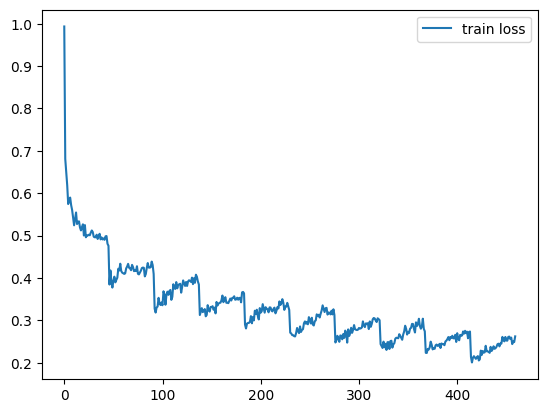

In [135]:
plt.plot(train_losses, label="train loss")
plt.legend()
plt.show()

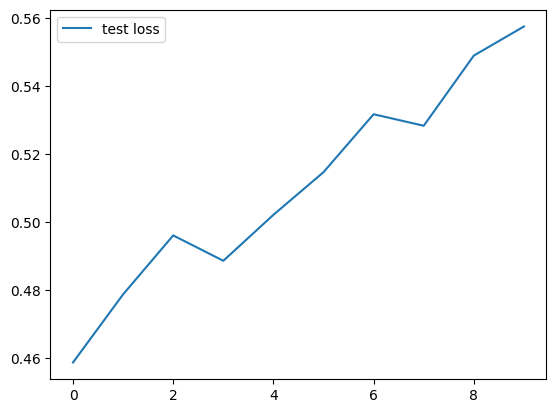

In [136]:
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

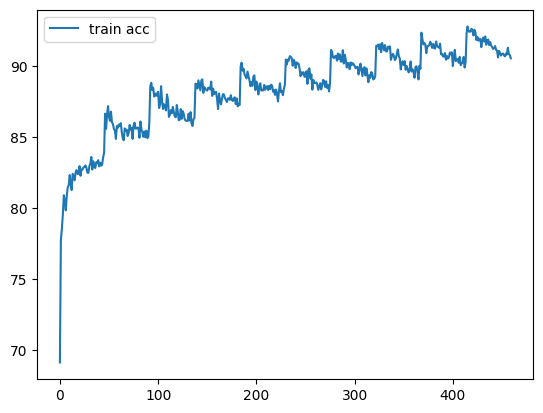

In [137]:
plt.plot(train_acc, label="train acc")
plt.legend()
plt.show()

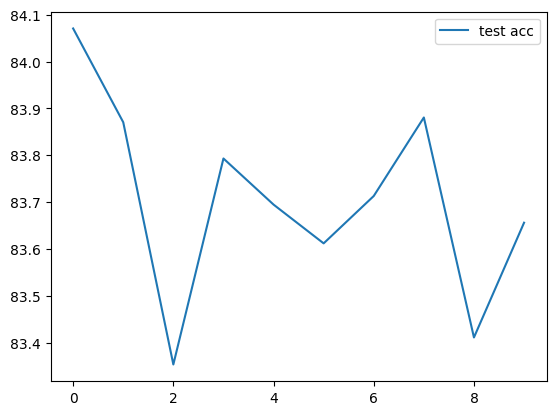

In [138]:
plt.plot(test_acc, label="test acc")
plt.legend()
plt.show()